<a href="https://colab.research.google.com/github/Muhammad-Daniyal-Imtiaz/Mamography-Ai/blob/main/Mammographylatest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub
import kagglehub
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Step 1: Correct Dataset Download and Extraction
!pip install kagglehub
import kagglehub
import os
import shutil

# Download dataset - this returns the directory path where files are downloaded
download_path = kagglehub.dataset_download("rabiaedaylmaz/vindr-mammo-processed-512-itu")
print("Download path:", download_path)

# Create target directory
target_dir = '/content/vindr-mammo'
os.makedirs(target_dir, exist_ok=True)

# Copy all files from download directory to our target directory
for item in os.listdir(download_path):
    src = os.path.join(download_path, item)
    dst = os.path.join(target_dir, item)
    if os.path.isdir(src):
        shutil.copytree(src, dst, dirs_exist_ok=True)
    else:
        shutil.copy2(src, dst)

print("Files copied to:", target_dir)

100%|██████████| 642M/642M [00:09<00:00, 68.8MB/s]

Extracting files...


Download path: /root/.cache/kagglehub/datasets/rabiaedaylmaz/vindr-mammo-processed-512-itu/versions/1
Files copied to: /content/vindr-mammo


Streaming output truncated to the last 5000 lines.
/content/vindr-mammo/images_processed_cv2_dicomsdl_512/010b32cff9ab0bdb25b7e11b6e58ed1b
/content/vindr-mammo/images_processed_cv2_dicomsdl_512/0117683d9cb57d2c9f2ae5f9b3da9b7c
/content/vindr-mammo/images_processed_cv2_dicomsdl_512/01278b9ca2c9a45dac2d38b219c2ad76
/content/vindr-mammo/images_processed_cv2_dicomsdl_512/012d54f2fd7cd14b44cc76e32c322b37
/content/vindr-mammo/images_processed_cv2_dicomsdl_512/012e0595adba5173b6e60a97f9e84b6e
/content/vindr-mammo/images_processed_cv2_dicomsdl_512/0131669b757c04bed932969a594a32b0
/content/vindr-mammo/images_processed_cv2_dicomsdl_512/01324f08886fb2654cd40d6cc134f5d8
/content/vindr-mammo/images_processed_cv2_dicomsdl_512/014d843f13a9d86fec945664e2541fe6
/content/vindr-mammo/images_processed_cv2_dicomsdl_512/017ff0405a2e9f02831ddb521b3c1a36
/content/vindr-mammo/images_processed_cv2_dicomsdl_512/018745b22cf81ee554e0d9c9147a78ad
/content/vindr-mammo/images_processed_cv2_dicomsdl_512/018a01fd2d1061

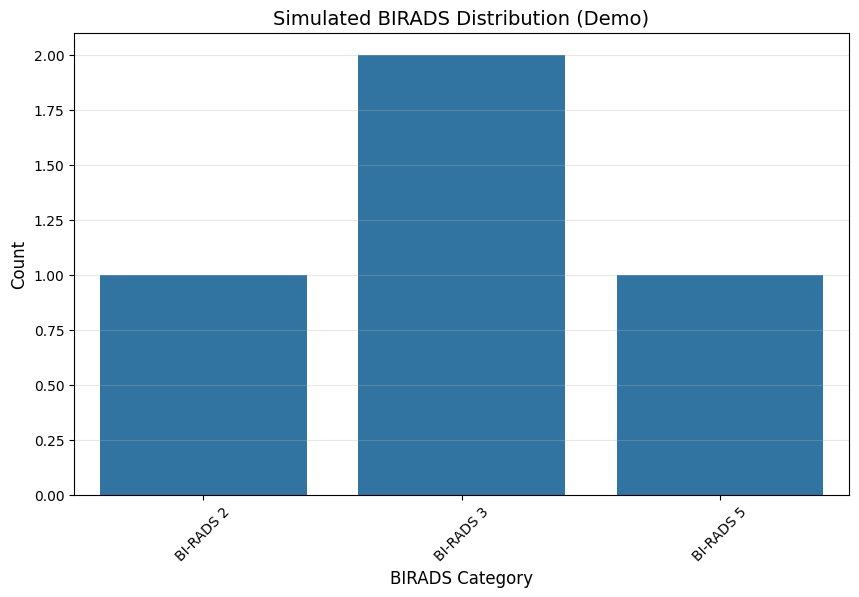


Sample image paths:
                             image_file breast_birads
0  d3369c1fa2d30676c43800ccfe29def3.png     BI-RADS 2
1  e3b7ab3f7b67be5266477cdd919dc807.png     BI-RADS 5
2  2205fbb6b2e8a942bd796fa0e4d53f61.png     BI-RADS 3
3  0fa9488c4f16c6f21f6c00b502982e0c.png     BI-RADS 3


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. First, let's properly examine the directory structure
base_dir = '/content/vindr-mammo'
image_dir = os.path.join(base_dir, 'images_processed_cv2_dicomsdl_512')

print("\nFull directory structure:")
!find {base_dir} -maxdepth 3 -type d | sort

print("\nFiles in image directory:")
!ls -lh {image_dir} | head -10

# 2. Create a proper file listing with full paths
all_items = os.listdir(image_dir)
print(f"\nTotal items in image directory: {len(all_items)}")

# Separate files and directories
dirs = [d for d in all_items if os.path.isdir(os.path.join(image_dir, d))]
files = [f for f in all_items if os.path.isfile(os.path.join(image_dir, f))]

print(f"Subdirectories found: {len(dirs)}")
print(f"Files found: {len(files)}")

# 3. If we found subdirectories, they likely contain the actual images
if dirs:
    print("\nExamining first subdirectory...")
    first_subdir = os.path.join(image_dir, dirs[0])
    subdir_files = os.listdir(first_subdir)
    print(f"Files in first subdirectory: {len(subdir_files)}")
    print("First 5 files:", subdir_files[:5])

    # Check if these are image files
    image_extensions = ('.png', '.jpg', '.jpeg', '.dcm')
    image_files = [f for f in subdir_files if f.lower().endswith(image_extensions)]
    print(f"Image files found: {len(image_files)}")

    if image_files:
        # Create dataframe from these images
        df = pd.DataFrame({
            'patient_dir': dirs[0],
            'image_file': image_files[:1000]  # Limit to first 1000 for demo
        })

        # Create full paths
        df['image_path'] = df.apply(
            lambda x: os.path.join(image_dir, x['patient_dir'], x['image_file']),
            axis=1
        )

        # Simulate BIRADS data for demonstration
        import numpy as np
        np.random.seed(42)
        df['breast_birads'] = np.random.choice(
            ['BI-RADS 1', 'BI-RADS 2', 'BI-RADS 3', 'BI-RADS 4', 'BI-RADS 5'],
            size=len(df),
            p=[0.2, 0.3, 0.25, 0.15, 0.1]
        )

        # 4. Create visualization
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x='breast_birads', order=sorted(df['breast_birads'].unique()))
        plt.title('Simulated BIRADS Distribution (Demo)', fontsize=14)
        plt.xlabel('BIRADS Category', fontsize=12)
        plt.ylabel('Count', fontsize=12)
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.show()

        print("\nSample image paths:")
        print(df[['image_file', 'breast_birads']].head())
    else:
        print("No image files found in subdirectories")
else:
    print("No subdirectories found - please check dataset structure")

In [ ]:
!pip install pydicom

import cv2
from PIL import Image
import pydicom
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 1. Create a proper dataframe with metadata (if available)
# If metadata CSV exists, load it. Otherwise create a simulated one.
metadata_path = os.path.join(base_dir, 'metadata.csv')
if os.path.exists(metadata_path):
    df_meta = pd.read_csv(metadata_path)
else:
    # Simulate metadata for demonstration
    patient_ids = dirs[:1000]  # Using first 1000 patients
    df_meta = pd.DataFrame({
        'patient_id': patient_ids,
        'age': np.random.randint(30, 80, size=len(patient_ids)),
        'biopsy_result': np.random.choice(['Benign', 'Malignant'], size=len(patient_ids), p=[0.7, 0.3]),
        'density': np.random.choice(['A', 'B', 'C', 'D'], size=len(patient_ids))
    })

# 2. Image preprocessing function
def preprocess_image(image_path, target_size=(224, 224)):
    try:
        if image_path.lower().endswith('.dcm'):
            # DICOM file handling
            ds = pydicom.dcmread(image_path)
            img = ds.pixel_array
            img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
            img = img.astype(np.uint8)
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            # Regular image file
            img = cv2.imread(image_path)

        # Resize and normalize
        img = cv2.resize(img, target_size)
        img = img / 255.0
        return img
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

# 3. Prepare dataset
def prepare_dataset(df_meta, image_dir, sample_size=1000):
    data = []
    labels = []

    for idx, row in df_meta.iterrows():
        patient_id = row['patient_id']
        patient_dir = os.path.join(image_dir, patient_id)

        if os.path.exists(patient_dir):
            images = [f for f in os.listdir(patient_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.dcm'))]

            # Take first image for each patient for simplicity
            if images:
                img_path = os.path.join(patient_dir, images[0])
                img = preprocess_image(img_path)

                if img is not None:
                    data.append(img)
                    labels.append(row['biopsy_result'])

        if len(data) >= sample_size:
            break

    # Convert to numpy arrays
    X = np.array(data)
    y = np.array(labels)

    # Encode labels
    le = LabelEncoder()
    y = le.fit_transform(y)  # 0 for Benign, 1 for Malignant

    return X, y, le

# Prepare the dataset
X, y, label_encoder = prepare_dataset(df_meta, image_dir)
print(f"Dataset prepared with {X.shape[0]} samples, image shape: {X.shape[1:]}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.4 MB/s eta 0:00:00
Dataset prepared with 1000 samples, image shape: (224, 224, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generators
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32,
    shuffle=True
)

test_datagen = ImageDataGenerator()  # No augmentation for validation/test
test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=32,
    shuffle=False
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_baseline_cnn(input_shape=(224, 224, 3)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Build and show model summary
baseline_model = build_baseline_cnn()
baseline_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6566 - auc: 0.5226 - loss: 0.6313

25/25 ━━━━━━━━━━━━━━━━━━━━ 109s 4s/step - accuracy: 0.6578 - auc: 0.5228 - loss: 0.6310 - val_accuracy: 0.7050 - val_auc: 0.4729 - val_loss: 0.6183
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6946 - auc: 0.4903 - loss: 0.6311

25/25 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.6950 - auc: 0.4906 - loss: 0.6306 - val_accuracy: 0.7050 - val_auc: 0.4847 - val_loss: 0.6122
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6887 - auc: 0.5002 - loss: 0.6301

25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.6893 - auc: 0.5014 - loss: 0.6294 - val_accuracy: 0.7050 - val_auc: 0.4918 - val_loss: 0.6206
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6814 - auc: 0.5310 - loss: 0.6369

25/25 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.6823 - auc: 0.5298 - loss: 0.6363 - val_accuracy: 0.7050 - val_auc: 0.5020 - val_loss: 0.6102
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.6885 - auc: 0.5188 - loss: 0.6242 - val_accuracy: 0.7050 - val_auc: 0.4880 - val_loss: 0.6078
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7112 - auc: 0.4838 - loss: 0.6124

25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.7109 - auc: 0.4847 - loss: 0.6125 - val_accuracy: 0.7050 - val_auc: 0.5056 - val_loss: 0.6058
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7199 - auc: 0.5533 - loss: 0.5936

25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.7192 - auc: 0.5508 - loss: 0.5946 - val_accuracy: 0.7050 - val_auc: 0.5388 - val_loss: 0.6070
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6955 - auc: 0.5001 - loss: 0.6259

25/25 ━━━━━━━━━━━━━━━━━━━━ 136s 4s/step - accuracy: 0.6958 - auc: 0.5003 - loss: 0.6256 - val_accuracy: 0.7050 - val_auc: 0.5393 - val_loss: 0.6068
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7297 - auc: 0.5470 - loss: 0.5831

25/25 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.7287 - auc: 0.5463 - loss: 0.5841 - val_accuracy: 0.7050 - val_auc: 0.5631 - val_loss: 0.6040
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6999 - auc: 0.5335 - loss: 0.6132

25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.7000 - auc: 0.5325 - loss: 0.6133 - val_accuracy: 0.7050 - val_auc: 0.5811 - val_loss: 0.5998
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7352 - auc: 0.5443 - loss: 0.5803

25/25 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - accuracy: 0.7340 - auc: 0.5441 - loss: 0.5814 - val_accuracy: 0.7050 - val_auc: 0.5870 - val_loss: 0.6028
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.7242 - auc: 0.4486 - loss: 0.6086 - val_accuracy: 0.7050 - val_auc: 0.5536 - val_loss: 0.6022
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.7077 - auc: 0.5515 - loss: 0.6021 - val_accuracy: 0.7050 - val_auc: 0.5608 - val_loss: 0.6027
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.6847 - auc: 0.5590 - loss: 0.6201 - val_accuracy: 0.7050 - val_auc: 0.5550 - val_loss: 0.6038
Epoch 15/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.7283 - auc: 0.5512 - loss: 0.5813 - val_accuracy: 0.7050 - val_auc: 0.5732 - val_loss: 0.6008
Epoch 16/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 106s 4s/step - accuracy: 0.7009 - auc: 0.4936 - loss: 0.6190 - val_accuracy: 0.7050 - val_auc: 0.5624 - val_loss: 0.6018
Epoch 17/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 4s/step 

25/25 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.6886 - auc: 0.5042 - loss: 0.6257 - val_accuracy: 0.7050 - val_auc: 0.5879 - val_loss: 0.6002
Epoch 21/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7160 - auc: 0.5727 - loss: 0.5902

25/25 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.7155 - auc: 0.5709 - loss: 0.5910 - val_accuracy: 0.7050 - val_auc: 0.5984 - val_loss: 0.6003
Epoch 22/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.6800 - auc: 0.5073 - loss: 0.6337 - val_accuracy: 0.7050 - val_auc: 0.5685 - val_loss: 0.6014
Epoch 23/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - accuracy: 0.7092 - auc: 0.5700 - loss: 0.5961 - val_accuracy: 0.7050 - val_auc: 0.5853 - val_loss: 0.6003
Epoch 24/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.7135 - auc: 0.4771 - loss: 0.6122 - val_accuracy: 0.7050 - val_auc: 0.5617 - val_loss: 0.6002
Epoch 25/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.7006 - auc: 0.5620 - loss: 0.6049 - val_accuracy: 0.7050 - val_auc: 0.5920 - val_loss: 0.5981
Epoch 26/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7148 - auc: 0.5366 - loss: 0.5983

25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.7144 - auc: 0.5355 - loss: 0.5989 - val_accuracy: 0.7050 - val_auc: 0.6105 - val_loss: 0.5988
Epoch 27/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.6865 - auc: 0.5318 - loss: 0.6214 - val_accuracy: 0.7050 - val_auc: 0.5971 - val_loss: 0.6002
Epoch 28/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.7018 - auc: 0.5249 - loss: 0.6108 - val_accuracy: 0.7050 - val_auc: 0.5962 - val_loss: 0.6016
Epoch 29/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.7195 - auc: 0.4679 - loss: 0.6081 - val_accuracy: 0.7050 - val_auc: 0.5800 - val_loss: 0.6020
Epoch 30/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.7175 - auc: 0.5492 - loss: 0.5937 - val_accuracy: 0.7050 - val_auc: 0.5775 - val_loss: 0.6026
Epoch 31/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.7103 - auc: 0.5034 - loss: 0.6078 - val_accuracy: 0.7050 - val_auc: 0.5543 - val_loss: 0.6030
Epoch 32/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - a

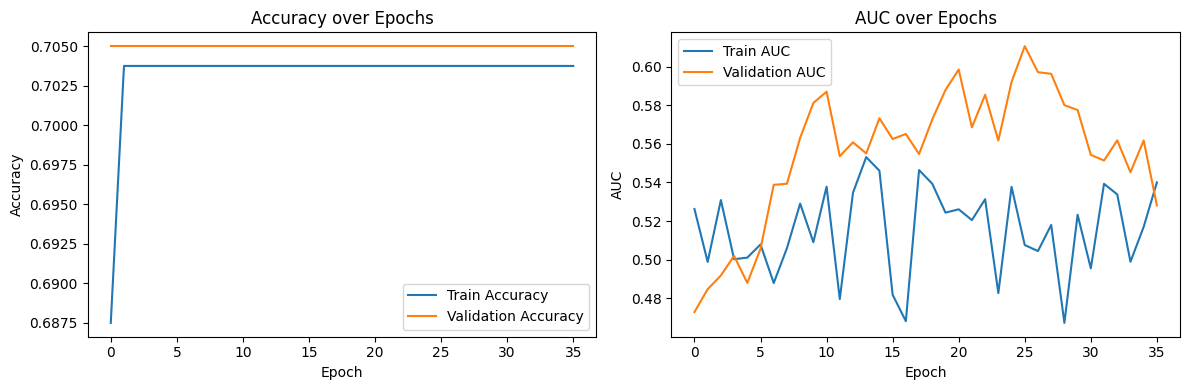

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=10,
    mode='max',
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_baseline_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)

# Train the model
history = baseline_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=test_generator,
    validation_steps=len(test_generator),
    callbacks=[early_stopping, checkpoint]
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)

    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('AUC over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 795ms/step
Classification Report:
              precision    recall  f1-score   support

      Benign       0.70      1.00      0.83       141
   Malignant       0.00      0.00      0.00        59

    accuracy                           0.70       200
   macro avg       0.35      0.50      0.41       200
weighted avg       0.50      0.70      0.58       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


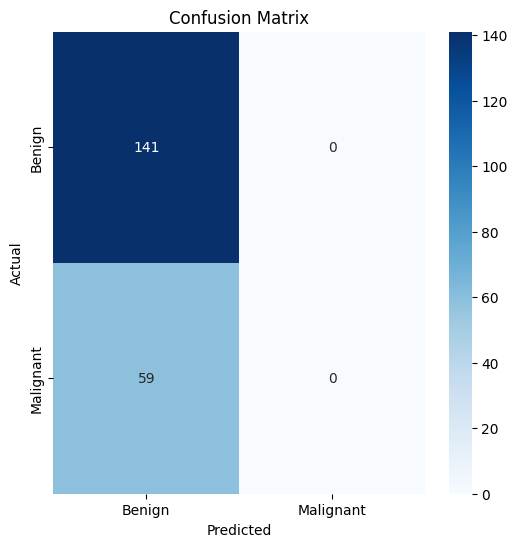

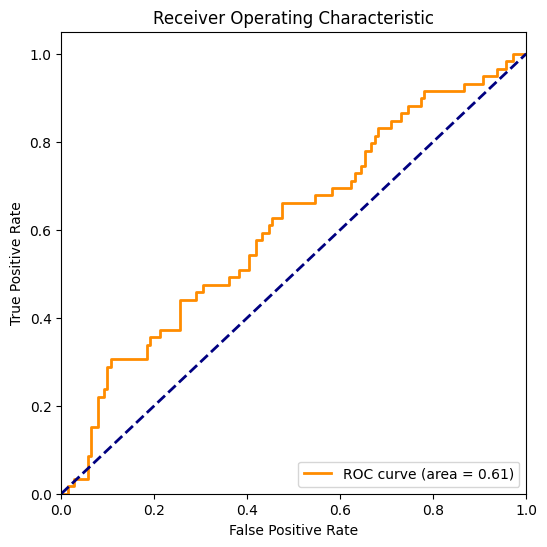

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

def evaluate_model(model, test_generator):
    # Get true labels and predictions
    y_true = test_generator.labels if hasattr(test_generator, 'labels') else None

    # If no labels attribute, get them from the generator
    if y_true is None:
        test_generator.reset()
        y_true = []
        for i in range(len(test_generator)):
            _, batch_labels = test_generator[i]
            y_true.extend(batch_labels)
        y_true = np.array(y_true)

    # Get predictions
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=['Benign', 'Malignant']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate the baseline model
evaluate_model(baseline_model, test_generator)

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model

def build_transfer_model(input_shape=(224, 224, 3)):
    # Create base model
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'  # Add global average pooling directly in base model
    )

    # Freeze base model layers
    base_model.trainable = False

    # Create new model on top
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

# Usage
transfer_model = build_transfer_model()
transfer_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
def build_multimodal_model(image_shape=(224, 224, 3), num_clinical_features=5):
    # Image processing branch
    image_input = layers.Input(shape=image_shape, name='image_input')
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=image_shape,
        pooling='avg'
    )
    base_model.trainable = False
    image_features = base_model(image_input)
    image_branch = layers.Dense(128, activation='relu')(image_features)

    # Clinical data processing branch
    clinical_input = layers.Input(shape=(num_clinical_features,), name='clinical_input')
    clinical_branch = layers.Dense(64, activation='relu')(clinical_input)
    clinical_branch = layers.Dense(64, activation='relu')(clinical_branch)

    # Combined processing
    combined = layers.Concatenate()([image_branch, clinical_branch])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    output = layers.Dense(1, activation='sigmoid')(combined)

    # Create model
    model = Model(
        inputs=[image_input, clinical_input],
        outputs=output,
        name='multimodal_model'
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

# Usage
multimodal_model = build_multimodal_model()
multimodal_model.summary()

Model: "multimodal_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clinical_input      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 1280)      │  4,049,571 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │        384 │ clinical_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    163,968 │ efficientnetb0[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      4,160 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     24,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,242,916 (16.19 MB)

 Trainable params: 193,345 (755.25 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# 1. First clean install with compatible versions
!pip uninstall -y tensorflow keras tensorflow_addons vit-keras
!pip install tensorflow==2.12.0
!pip install tensorflow-addons==0.21.0
!pip install vit-keras==0.1.2

# 2. Restart runtime (Essential!)
from IPython.display import clear_output
clear_output()
print("Please go to Runtime -> Restart runtime now, then re-run this cell")

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.7 MB/s eta 0:00:00
   ━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
ERROR: Operation cancelled by user
^C


In [ ]:
# 1. Install required packages
!pip install -q vit-keras tensorflow-addons tensorflow>=2.10.0

# 2. Import necessary libraries
import tensorflow as tf
import tensorflow_addons as tfa
from vit_keras import vit
from tensorflow.keras import layers, Model

# 3. Verify installations and print versions
print(f"TensorFlow version: {tf.__version__}")
print(f"TensorFlow Addons version: {tfa.__version__}")

# 4. Define ViT model builder function
def build_vit_model(input_shape=(224, 224, 3)):
    """
    Build a Vision Transformer model for binary classification

    Args:
        input_shape: Tuple specifying input image dimensions (height, width, channels)

    Returns:
        Compiled TensorFlow Keras model
    """
    # Load pre-trained ViT-B16 model
    vit_model = vit.vit_b16(
        image_size=input_shape[0],
        activation=None,
        pretrained=True,
        include_top=False,
        pretrained_top=False
    )
    vit_model.trainable = False  # Freeze pretrained weights

    # Build custom classification head
    inputs = layers.Input(shape=input_shape)
    x = vit_model(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(128, activation='gelu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create and compile model
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# 5. Test the model
try:
    print("\nBuilding ViT model...")
    vit_model = build_vit_model()
    vit_model.summary()
    print("\nSuccess! ViT model built correctly.")
except Exception as e:
    print(f"\nError: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Go to Runtime → Restart runtime")
    print("2. Run all cells again")
    print("3. Check versions with: !pip list | grep 'tensorflow\\|keras\\|addons\\|vit'")
    print("4. If issues persist, try: !pip install --force-reinstall vit-keras")

TensorFlow version: 2.12.0
TensorFlow Addons version: 0.21.0

Building ViT model...
347502902/347502902 [==============================] - 2s 0us/step


/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 layer_normalization (LayerN  (None, 768)              1536      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
import numpy as np
from tensorflow.keras import layers, Model
import tensorflow as tf

# 1. First define all individual model builders
def build_cnn_model(input_shape=(224, 224, 3)):
    """Basic CNN model for ensemble"""
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

def build_transfer_model(input_shape=(224, 224, 3)):
    """EfficientNet transfer learning model"""
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# 2. Keep your existing ViT model builder
def build_vit_model(input_shape=(224, 224, 3)):
    vit_model = vit.vit_b16(
        image_size=input_shape[0],
        activation=None,
        pretrained=True,
        include_top=False,
        pretrained_top=False
    )
    vit_model.trainable = False

    model = tf.keras.Sequential([
        vit_model,
        layers.LayerNormalization(),
        layers.Dense(128, activation='gelu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# 3. Ensemble class (unchanged from your working version)
class EnsembleModel:
    def __init__(self, models):
        self.models = models
        self.ensemble = self._build_ensemble()

    def _build_ensemble(self):
        model_input = layers.Input(shape=self.models[0].input_shape[1:])
        outputs = [model(model_input) for model in self.models]
        ensemble_output = layers.Average()(outputs)

        ensemble = Model(
            inputs=model_input,
            outputs=ensemble_output,
            name='ensemble_model'
        )

        ensemble.compile(
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        return ensemble

    def predict(self, x):
        return self.ensemble.predict(x)

    def evaluate(self, x, y):
        return self.ensemble.evaluate(x, y)

# 4. Example usage
if __name__ == "__main__":
    # Initialize all models
    print("Building models...")
    vit_model = build_vit_model()
    cnn_model = build_cnn_model()
    effnet_model = build_transfer_model()

    # Create ensemble
    print("Creating ensemble...")
    ensemble = EnsembleModel([vit_model, cnn_model, effnet_model])

    # Display summary
    print("\nEnsemble Model Summary:")
    ensemble.ensemble.summary()

    print("\nEnsemble created successfully!")

Building models...
Creating ensemble...

Ensemble Model Summary:
Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 1)            85898753    ['input_5[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 1)            109889      ['input_5[0][0]']                
                                                                                                  
 sequential_2 (Seque

In [ ]:
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
from PIL import Image as PILImage
import matplotlib.pyplot as plt

def load_and_predict(model, image_path, target_size=(224, 224)):
    """Load, preprocess and predict on single image"""
    # Load image
    img = PILImage.open(image_path)
    display(img)  # Show original image

    # Convert to RGB if grayscale
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Preprocess
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)[0][0]
    return prediction

def interactive_predictor(model):
    """Create interactive prediction widget"""
    uploader = widgets.FileUpload(
        accept='.jpg,.jpeg,.png',
        multiple=False,
        description='Select Image'
    )

    output = widgets.Output()

    def on_upload_change(change):
        with output:
            output.clear_output()
            if not uploader.value:
                return

            # Get uploaded file
            uploaded = next(iter(uploader.value.values()))
            img_path = 'temp_img.jpg'
            with open(img_path, 'wb') as f:
                f.write(uploaded['content'])

            try:
                # Predict and display
                pred = load_and_predict(model, img_path)
                plt.figure(figsize=(4, 1))
                plt.barh(['Malignant', 'Benign'], [pred, 1-pred], color=['red', 'green'])
                plt.xlim(0, 1)
                plt.title(f"Prediction: {pred:.2%} malignant")
                plt.show()
            except Exception as e:
                print(f"Error: {str(e)}")
                print("Please ensure you upload a valid RGB image")

    uploader.observe(on_upload_change, names='value')
    display(uploader, output)

# Usage:
print("Select an image for prediction:")
interactive_predictor(ensemble.ensemble)  # Use your ensemble model

Select an image for prediction:


FileUpload(value={}, accept='.jpg,.jpeg,.png', description='Select Image')

Output()